# Игры — Анализ рекламных источников 

## 1. Описание проекта
<ins> Контекст:</ins>

Отдел маркетинга просит провести исследовательский анализ данных, чтобы понять, насколько рационально расходуются деньги, выделяемые на привлечение пользователей в мобильную игру "Космические братья".

В настоящий момент в игру еще не встроена система монетизации, поэтому отдел маркетинга ожидает, что сравнение каналов привлечения будет проведено на основе анализа игрового поведения пользователй.

Монетизацией игры занимается соседняя команда, но предварительно предполагается, что в приложении будет происходить показ рекламы на экране с выбором типа объекта для постройки. Исходя из этой информации необходимо самостоятельно выделить фичи для сравнения каналов привлечения, которые могли бы характеризовать более "прибыльных" пользователей. 



<ins> Предоставленные заказчиком данные: </ins>

Датасет *game_actions.csv*:
- event_datetime — время события;
- event — одно из трёх событий:
    - building — объект построен,
    - finished_stage_1 — первый уровень завершён,
    - project — проект завершён;
- building_type — один из трёх типов здания:
    - assembly_shop — сборочный цех,
    - spaceport — космопорт,
    - research_center — исследовательский центр;
- user_id — идентификатор пользователя;
- project_type — тип реализованного проекта;

Датасет *ad_costs.csv*:
- day - день, в который был совершен клик по объявлению;
- source - источник трафика;
- cost - стоимость кликов;

Датасет *user_source.csv*:
- user_id - идентификатор пользователя;
- source - источников, с которого пришёл пользователь, установивший приложение;


<ins> Информация от заказчика о игре и внутренней логике данных: </ins>

- Игра "Космические братья", со слов заказчика, по своей игровой механике похожа на "Clash of clans" в космическом сетинге (или на любую другую игру в жанре real time strategy). 
- Как и в других RTS основной задачей игрока на начальном этапе игры является постройка базы. При этом он может строить три типа зданий: 
    - assembly_shop: здание для найма рабочих;
    - spaceport: здание для найма войнов;
    - research_center - здание для проведения технологических исследований;
- Игра находится на стадии тестирования, поэтому в игре пока что очень мало контента. Так, среди возможных проектов, которые можно выполнить в исследовательском центре, представлен только один: satellite_orbital_assembly;
- В игре присутствует как PVE, так и PVP режим. PVE игроки отличаются от PVP игроков тем, что для перехода на первый уровень (событие finished_stage_1) им необходимо завершить проект в исследовательском центре;
- Заказчик предоставил датасет ad_costs, который хранит информацию о закупке рекламы. Есть уточнение, что колонка 'day' хранит информацию о дате оплаты рекламы. Сами же пользователи привлекались на следующий день.


<ins> Предварительный план решения: </ins>
- Выполнить обзор данных;
- Предобработка данных, в свою очередь состоящая из следующих шагов:
    - Поиск дубликатов;
    - Обработка пропущенных значений;
    - Поиск аномалий;
    - Создание новых фичей;
- Исследовательский анализ данных, основной задачей которого является ранжирование каналов привлечения новых пользователей с точки зрения стоимости привлечения и поведенческой активности игроков; 
- Статистический анализ данных;
    - Проверка гипотезы о том, что время завершения уровня различается у PVP и PVE игроков;
    - Сформулировать и проверить гипотезу, целью которой будет проверка выводов из исследовательского анализа на статистическую значимость. К примеру, пользователи из канала "А" проводят в игре больше времени, нежели пользователи из канала "Б".
- Финальный вывод.

## 2. Обзор данных

In [1]:
# Подключаем необходимые библиотеки:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as st
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Считываем полученные данные:
try:
    ad_costs = pd.read_csv('ad_costs.csv')
    game_actions = pd.read_csv('game_actions.csv')
    user_source = pd.read_csv('user_source.csv')
except:
    ad_costs = pd.read_csv('/datasets/ad_costs.csv')
    game_actions = pd.read_csv('/datasets/game_actions.csv')
    user_source = pd.read_csv('/datasets/user_source.csv')

In [3]:
# Посмотрим на содержание предоставленных датафреймов:
display(ad_costs.sample(3))
display(game_actions.sample(3))
display(user_source.sample(3))

,source,day,cost
13,instagram_new_adverts,2020-05-09,46.775400
5,facebook_ads,2020-05-08,68.009276
23,youtube_channel_reklama,2020-05-05,147.041741


,event_datetime,event,building_type,user_id,project_type
21323,2020-05-06 10:10:52,building,assembly_shop,b1eddf04-4402-4428-9ccd-b18a9475950b,NaN
60759,2020-05-09 19:47:53,building,assembly_shop,9939868a-be68-4670-a78b-8552e13130ca,NaN
5565,2020-05-04 16:42:36,building,assembly_shop,75427c06-e901-4a44-b4ce-fb27820e8278,NaN


,user_id,source
3423,3f0c3a4a-ce62-4f0f-9211-255f506f1d3e,yandex_direct
10835,ccbc4d2e-7537-43e6-95d4-62382a992914,youtube_channel_reklama
6235,74161718-eb8e-433f-8d3b-b7d08be9b419,facebook_ads


In [4]:
# Проверим данные на наличие пропусков, а также на соответствие типов:
display(ad_costs.info())
display(game_actions.info())
display(user_source.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  28 non-null     object 
 1   day     28 non-null     object 
 2   cost    28 non-null     float64
dtypes: float64(1), object(2)
memory usage: 800.0+ bytes


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135640 entries, 0 to 135639
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   event_datetime  135640 non-null  object
 1   event           135640 non-null  object
 2   building_type   127957 non-null  object
 3   user_id         135640 non-null  object
 4   project_type    1866 non-null    object
dtypes: object(5)
memory usage: 5.2+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13576 entries, 0 to 13575
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  13576 non-null  object
 1   source   13576 non-null  object
dtypes: object(2)
memory usage: 212.2+ KB


None

In [5]:
# Проверим столбец 'cost' датафрейма ad_costs на выбросы:
ad_costs.describe()

,cost
count,28.000000
mean,271.556321
std,286.867650
min,23.314669
25%,66.747365
50%,160.056443
75%,349.034473
max,969.139394


- В датасете game_actions присутствуют пропуски в столбцах 'building_type', 'project_type'.
- Столбец 'event_datetime' датафрейма game_actions может быть приведен к типу datetime. Аналогичная ситуация с колонкой 'day' таблицы ad_costs

## 3. Предобработка данных

### 3.1 Проверка соответствия данных необходимым типам

In [6]:
# Приведём столбцы 'day', 'event_datetime' датафреймов ad_costs, game_actions к типу datetime:
ad_costs['day'] = pd.to_datetime(ad_costs['day'],
                                 format = '%Y-%m-%d')
game_actions['event_datetime'] = pd.to_datetime(game_actions['event_datetime'],
                                                format = '%Y-%m-%d %H:%M:%S')

### 3.2 Поиск дубликатов

In [7]:
# Проверим данные на наличие полных дубликатов:
print("В датафрейме ad_costs содержится {} явных дубликатов, что составляет {} % от всего датафрейма".format(ad_costs.duplicated().sum(), ad_costs.duplicated().sum() / len(ad_costs)))
print("В датафрейме ad_costs содержится {} явных дубликатов, что составляет {} % от всего датафрейма".format(game_actions.duplicated().sum(), game_actions.duplicated().sum() / len(game_actions)))
print("В датафрейме ad_costs содержится {} явных дубликатов, что составляет {} % от всего датафрейма".format(user_source.duplicated().sum(), user_source.duplicated().sum() / len(user_source)))

В датафрейме ad_costs содержится 0 явных дубликатов, что составляет 0.0 % от всего датафрейма
В датафрейме ad_costs содержится 1 явных дубликатов, что составляет 7.372456502506635e-06 % от всего датафрейма
В датафрейме ad_costs содержится 0 явных дубликатов, что составляет 0.0 % от всего датафрейма


In [8]:
# Выведем строку, являющуюся дубликатом:
game_actions[game_actions.duplicated()]

,event_datetime,event,building_type,user_id,project_type
74891,2020-05-10 18:41:56,building,research_center,c9af55d2-b0ae-4bb4-b3d5-f32aa9ac03af,NaN


In [9]:
# Избавимся от полных дубликатов:
game_actions.drop_duplicates(inplace = True)

In [10]:
# Определим функцию для вывода уникальных значений в интересующих нас столбцах:
def unique_values(df, columns):
    for column in columns:
        display(df[column].unique())

In [11]:
# Проверим полученные данные на наличие неявных дубликатов:
unique_values(ad_costs, ad_costs.columns.drop(['day', 'cost']))
unique_values(game_actions, game_actions.columns.drop(['user_id', 'event_datetime']))
unique_values(user_source, user_source.columns.drop('user_id'))

array(['facebook_ads', 'instagram_new_adverts', 'yandex_direct',
       'youtube_channel_reklama'], dtype=object)

array(['building', 'finished_stage_1', 'project'], dtype=object)

array(['assembly_shop', 'spaceport', nan, 'research_center'], dtype=object)

array([nan, 'satellite_orbital_assembly'], dtype=object)

array(['facebook_ads', 'yandex_direct', 'youtube_channel_reklama',
       'instagram_new_adverts'], dtype=object)

- Неявные дубликаты отсутствуют;
- Полные дубликаты были удалены из данных.

### 3.3 Поиск аномалий

#### 3.3.1 Проверим, что каждый пользователь, завершивший проект, построил 'research_center':

In [12]:
# Посчитаем, сколько пользователей завершило проект 'satellite_orbital_assembly':
users_who_finished_project = game_actions.query('project_type == "satellite_orbital_assembly"')['user_id'].unique()
print("Всего {} пользоваетелей завершило проект".format(len(users_who_finished_project)))

Всего 1866 пользоваетелей завершило проект


In [13]:
# Посчитаем, сколько из этих пользователей, построило исследовательский центр:
users_who_built_research_center = game_actions[game_actions['user_id'].isin(users_who_finished_project)].query('building_type =="research_center"')['user_id'].unique()
print("Среди пользователей, завершивших проект, {} пользователей построило исследовательский центр".format(len(users_who_built_research_center)))

Среди пользователей, завершивших проект, 1866 пользователей построило исследовательский центр


- Противоречий нет.

### 3.4 Обработка пропусков

В предоставленном датафрейме пропуски отражают логику данных. Так, при выполнении проекта 'satellite_orbital_assembly' в столбце 'building_type' должен быть пропуск. Аналогичная ситуация при строительстве зданий: должны быть пропуски в столбце 'project_type'. Проверим данные утверждения:

In [14]:
# При исследовании прокта должен быть пропуск в 'building_type':
game_actions.query('project_type == "satellite_orbital_assembly"')['building_type'].value_counts()

Series([], Name: building_type, dtype: int64)

In [15]:
# При строительстве здания должен быть пропуск в 'project_type':
game_actions.query('event == "building"')['project_type'].value_counts()

Series([], Name: project_type, dtype: int64)

In [16]:
# При переходе на второй уровень должен быть пропуск в 'project_type':
game_actions.query('event == "finished_stage_1"')['project_type'].value_counts()

Series([], Name: project_type, dtype: int64)

In [17]:
# При переходе на второй уровень должен быть пропуск в 'building_type':
game_actions.query('event == "finished_stage_1"')['building_type'].value_counts()

Series([], Name: building_type, dtype: int64)

In [18]:
# При переходе на второй уровень должен быть пропуск в 'project_type':
game_actions.query('event == "finished_stage_1"')['project_type'].value_counts()

Series([], Name: project_type, dtype: int64)

In [19]:
# При выполнении проекта должен быть пропуск в 'building_type'
game_actions.query('event == "project"')['building_type'].value_counts()

Series([], Name: building_type, dtype: int64)

In [20]:
# При выполнении проекта не должно быть пропусков в 'project_type'
game_actions.query('event == "project"')['project_type'].value_counts()

satellite_orbital_assembly    1866
Name: project_type, dtype: int64

In [21]:
# При выполнении проекта не должно быть пропусков в 'event'
game_actions.query('project_type == "satellite_orbital_assembly"')['event'].value_counts()

project    1866
Name: event, dtype: int64

In [22]:
# При строительстве здания не должно быть пропусков в 'event'
game_actions.query('event == "building"')['building_type'].value_counts()

spaceport          59325
assembly_shop      54494
research_center    14137
Name: building_type, dtype: int64

## 4. Исследовательский анализ данных

### 4.1 Различается ли удержание пользователей из разных каналов (retention rate)?

In [23]:
# Подготовим сводный датафрейм для расчёта retention rate в разбивке по каналам привлечения:

# Добавим в датафрейм game_actions отдельный столбец с датой события:
game_actions['date'] = game_actions['event_datetime'].dt.date
# Мерджим датафреймы game_actions и user_source, чтобы каждому пользователю был сопоставлен канал привлечения:
users = game_actions.merge(user_source, how = 'inner', on = 'user_id') 

# Определяем для каждого пользователя минимальную и максимальную дату присутствия в игре. 
# Также рассчитываем количество уникальных дней, проведенных в игре, для каждого пользователя:
days_in_game = game_actions.groupby('user_id').agg(min_date = ('date',  'min'),
                                    max_date = ('date', 'max'),
                                    days_in_game_present = ('date', 'nunique'))
users = users.merge(days_in_game, how = 'inner', on = 'user_id')

# Определяем lifetime для каждого события:
users['event_lifetime'] = (users['date'] - users['min_date'])

# Создаём сводную таблицу для визуализации retention rate в разбивке по каналам:
retention = (pd.pivot_table(data = users, columns = 'source',
                            index = ['min_date', 'event_lifetime'],
                            values = 'user_id',
                            aggfunc = 'nunique').reset_index()
                                            
            )
retention['event_lifetime'] = retention['event_lifetime'].dt.days

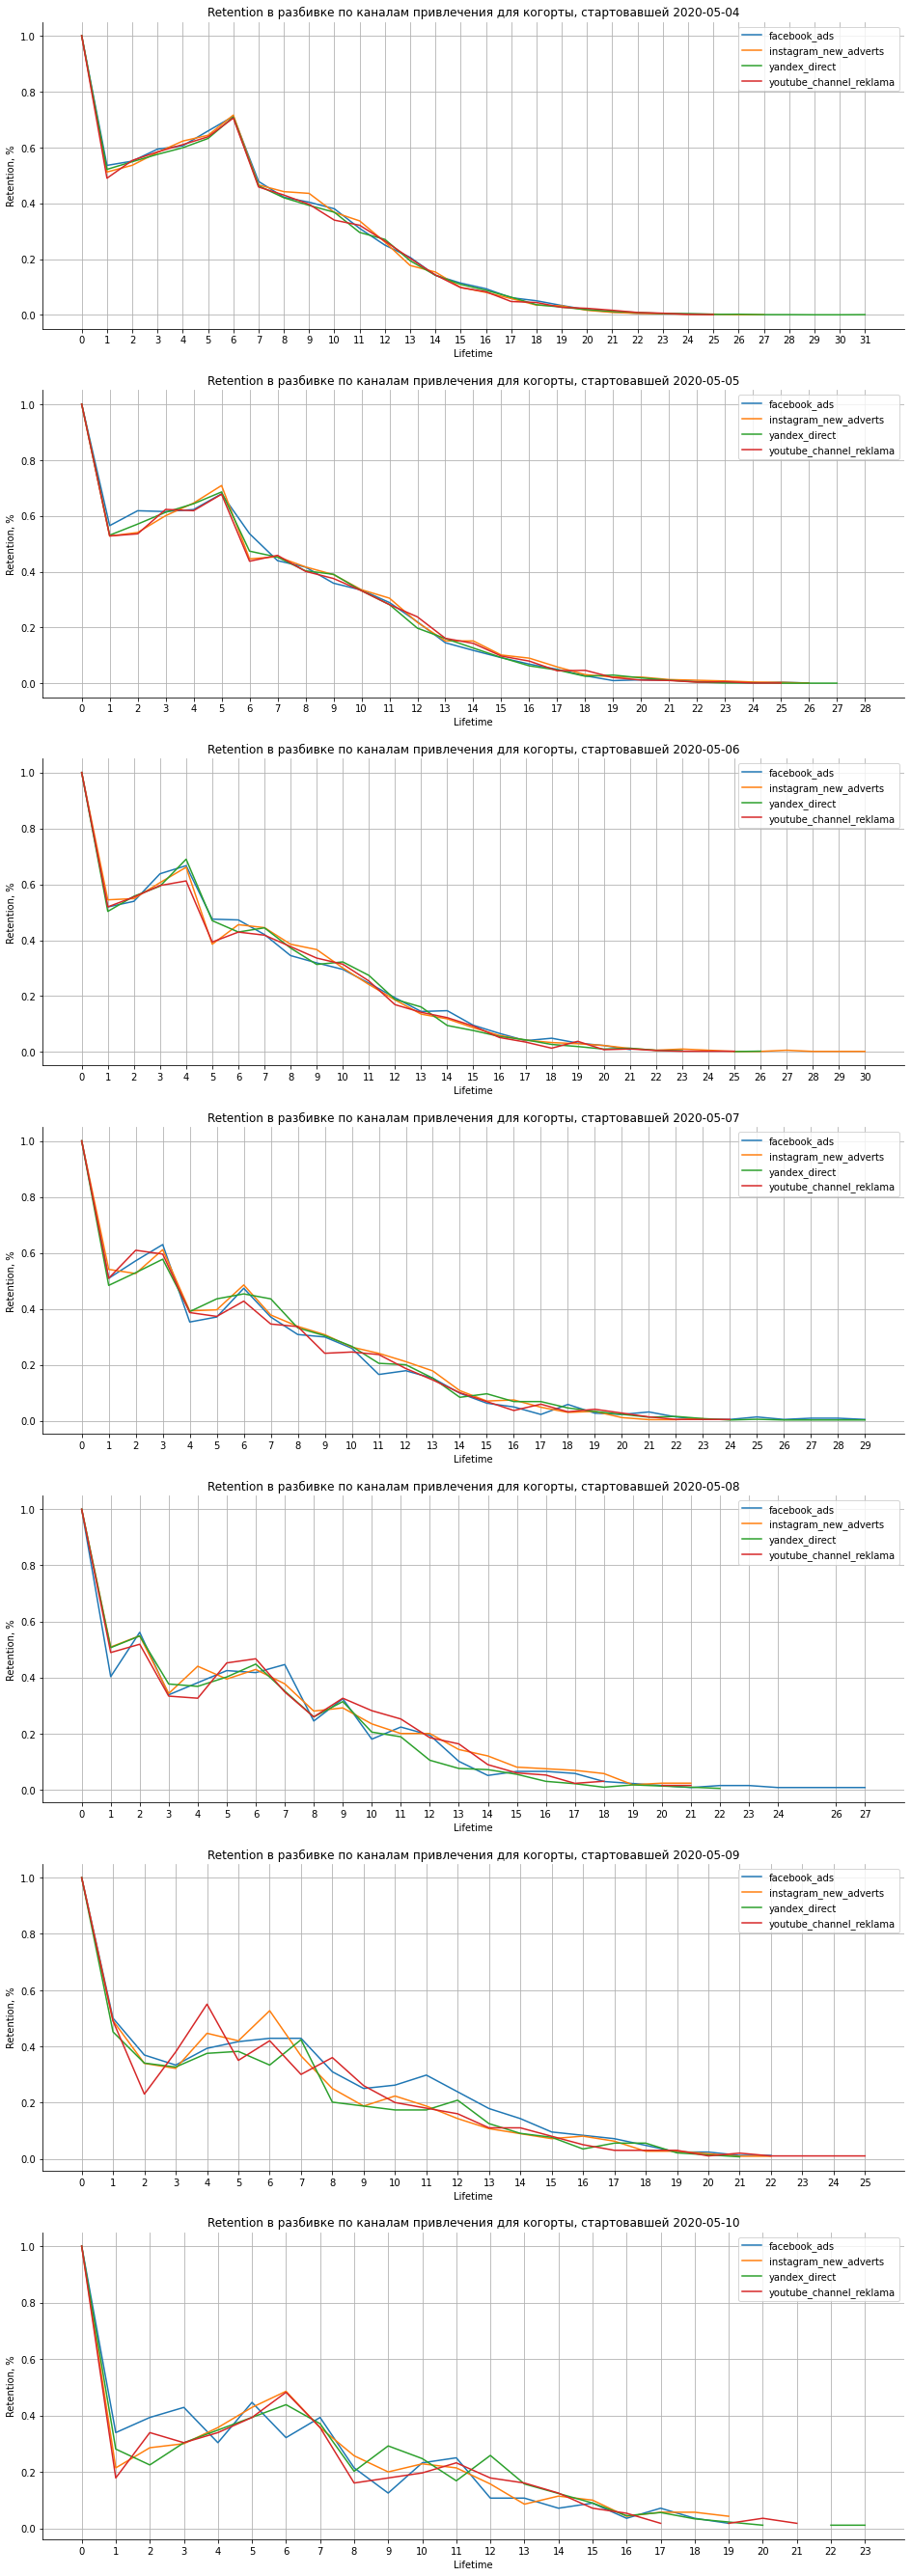

In [24]:
# Визуализируем удержание пользователей:
plt.figure(figsize=(16, 48))
i = 1
for date in retention['min_date'].unique():
    df = retention.query('min_date == @date')
    df[['facebook_ads',
        'instagram_new_adverts',
        'yandex_direct',
        'youtube_channel_reklama']] = df[['facebook_ads',
                                          'instagram_new_adverts',
                                          'yandex_direct',
                                          'youtube_channel_reklama']].div(df[['facebook_ads',
                                                                              'instagram_new_adverts',
                                                                              'yandex_direct',
                                                                              'youtube_channel_reklama']].iloc[0])
    #display(df)
    x = df['event_lifetime']
    y = df[['facebook_ads', 'instagram_new_adverts', 'yandex_direct', 'youtube_channel_reklama']]
    ax = plt.subplot(7, 1, i)
    sns.despine()
    ax.plot(x, y)
    plt.grid(True)
    ax.set_title("Retention в разбивке по каналам привлечения для когорты, стартовавшей {}". format(date))
    ax.set_xticks(x)
    ax.set_xlabel("Lifetime")
    ax.set_ylabel("Retention, %")
    ax.legend(df[['facebook_ads', 'instagram_new_adverts', 'yandex_direct', 'youtube_channel_reklama']].columns)
    i += 1
plt.show()

- Построенные графики говорят о том, что значимых различий в удержании пользователей между когортами нет.

### 4.2 Пользователи из какого канала самые дорогие?

In [25]:
# На этапе уточнения ТЗ было определено, что данные в столбце ad_costs['day'] соответствуют дате оплаты 
# рекламной компании. Сами же пользователи привлекались на следующий день. Увеличим значения в столбце 
# ad_costs['day'] на один день, чтобы в дальнейшем связать предоставленные датафреймы друг с другом:
ad_costs['day'] = ad_costs['day'] + pd.DateOffset(1)

In [26]:
# Рассчитаем, сколько уникальных пользователей из каких источников пришло в каждый день рекламной компании:
unique_users_per_source = (users.groupby(['source', 'min_date'])
                                .agg(unique_users = ('user_id', 'nunique'))
                                .reset_index()
                          )

In [27]:
# Приведём значения колонки unique_users_per_source['min_date'] к datetime для дальнейшего мёрджа:
unique_users_per_source['min_date'] = pd.to_datetime(unique_users_per_source['min_date'],
                                                     format = '%Y-%m-%d')

In [28]:
# Мёрджим датафреймы, чтобы получить полные данные о рекламной компании:
unique_users_per_source = ad_costs.merge(unique_users_per_source,
                                         how = 'outer',
                                         right_on = ['source', 'min_date'],
                                         left_on = ['source', 'day'])

In [29]:
# Избавляемся от дублирующихся столбцов:
unique_users_per_source.drop('day', axis = 1, inplace = True)

In [30]:
# Определим удельную стоимость привлеченного пользователя:
unique_users_per_source['cost_per_user'] = unique_users_per_source['cost'] / unique_users_per_source['unique_users']

In [31]:
# Подготовим новый датафрейм для расчёта итогов рекламной компании без разбивки по источникам:
total_costs = unique_users_per_source.groupby('source', as_index = False).agg(total_users = ('unique_users', 'sum'),
                                                                              total_cost = ('cost', 'sum'))
total_costs['cost_per_user'] = total_costs['total_cost'] / total_costs['total_users']

In [32]:
# Отсортируем полученный датафрейм:
total_costs = total_costs.sort_values(by = ['total_cost', 'total_users'], ascending = False)

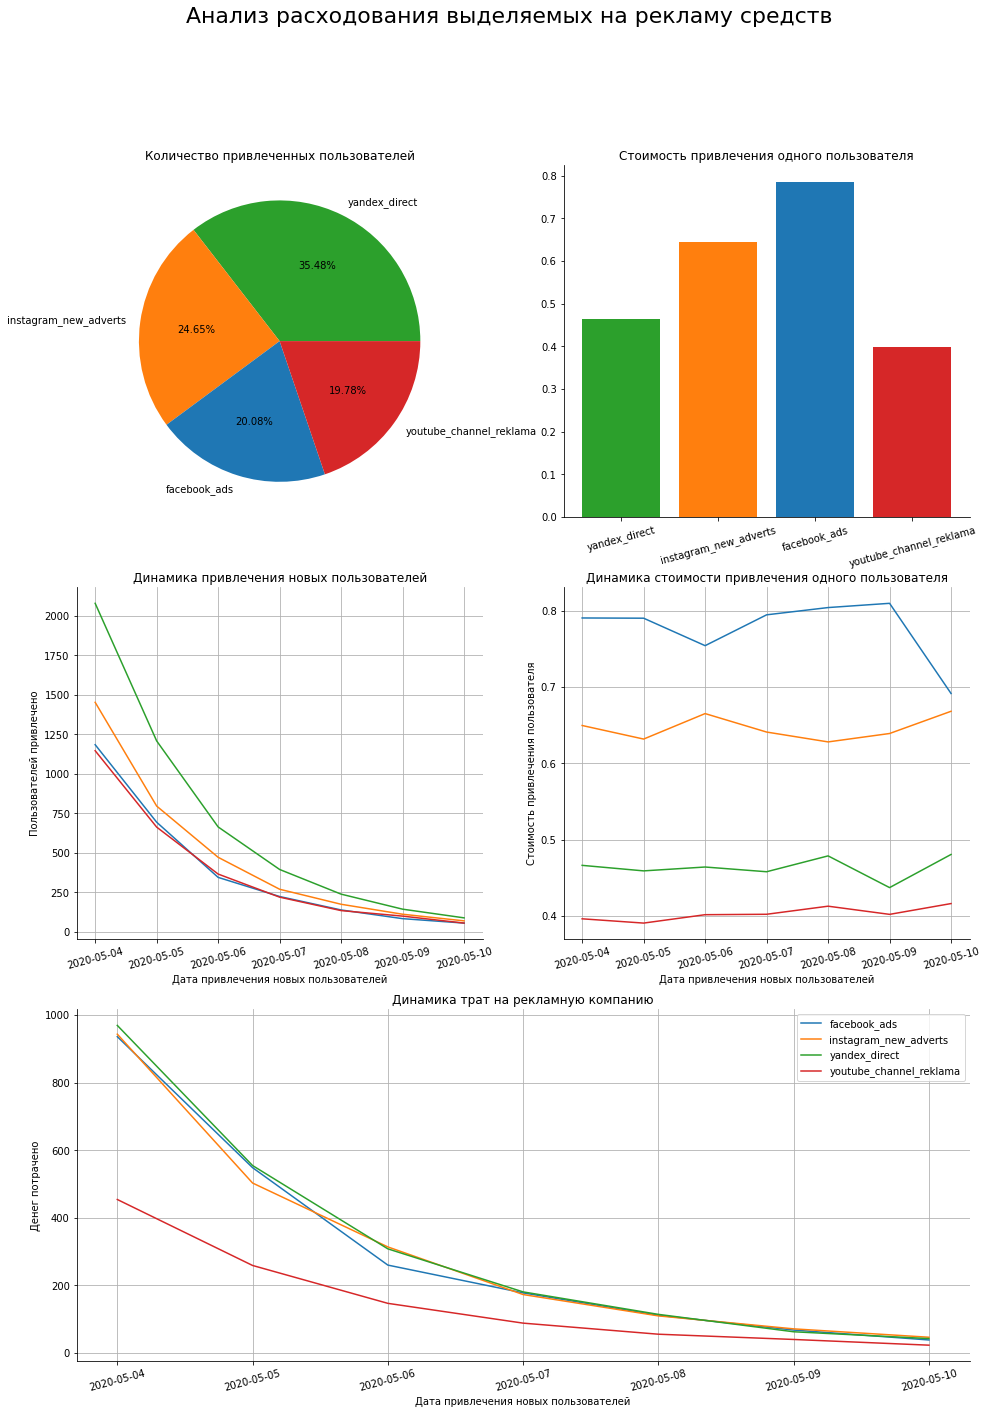

In [33]:
# Визуализируем интерисующие нас метрики:
plt.figure(figsize=(16, 22)).suptitle('Анализ расходования выделяемых на рекламу средств', fontsize = 22)
plt.subplot(3, 2, 1)
plt.pie(total_costs['total_users'],
        labels = total_costs['source'],
        normalize = True,
        autopct='%.2f%%',
        colors = ['tab:green', 'tab:orange', 'tab:blue', 'tab:red'])
plt.title("Количество привлеченных пользователей")

plt.subplot(3, 2, 2)
plt.bar(data = total_costs,
        height = 'cost_per_user',
        x = 'source',
        color = ['tab:green', 'tab:orange', 'tab:blue', 'tab:red'])
sns.despine()
plt.xticks(rotation = 15)
plt.title("Стоимость привлечения одного пользователя")


for source in unique_users_per_source['source'].unique():
    df = unique_users_per_source.query('source == @source')
    x = df['min_date']
    y = df['unique_users']
    ax = plt.subplot(3, 2, 3)
    ax.plot(x, y)
    sns.despine()
    plt.xticks(rotation = 15)
    plt.grid(True)
    ax.set_xlabel("Дата привлечения новых пользователей")
    ax.set_ylabel("Пользователей привлечено")
    ax.set_title("Динамика привлечения новых пользователей")

    
for source in unique_users_per_source['source'].unique():
    df = unique_users_per_source.query('source == @source')
    x = df['min_date']
    y = df['cost']
    ax = plt.subplot(3, 2, (5, 6))
    ax.plot(x, y)
    sns.despine()
    plt.xticks(rotation = 15)
    plt.grid(True)
    ax.set_xlabel("Дата привлечения новых пользователей")
    ax.set_ylabel("Денег потрачено")
    ax.set_title("Динамика трат на рекламную компанию")
    ax.legend(unique_users_per_source['source'].unique())
    
for source in unique_users_per_source['source'].unique():
    df = unique_users_per_source.query('source == @source')
    x = df['min_date']
    y = df['cost_per_user']
    ax = plt.subplot(3, 2, 4)
    ax.plot(x, y)
    sns.despine()
    plt.xticks(rotation = 15)
    plt.grid(True)
    ax.set_xlabel("Дата привлечения новых пользователей")
    ax.set_ylabel("Стоимость привлечения пользователя")
    ax.set_title("Динамика стоимости привлечения одного пользователя")


plt.show()

- Стоимость привлечения одного пользователя из каждого отдельно взятого канала оставалась стабильной на протяжении всей рекламной компании. При этом пользователи из каналов facebook_ads и instagram_new_advers обходились заметно дороже для рекламного бюджета, нежели пользователи из каналов yandex_direct и youtube_channel_reklama. Так, стоимость пользователей из канала facebook_ads(0.79) в два раза больше стоимости пользователей из канала youtube_channel_reklama(0.40), а пользователи из канала instagram_new_advers(0.65) почти в полтора раза дороже чем пользователи из канала yandex_direct(0.46).
- Больше всего пользователей было привлечено из каналов yandex_direct(35%) и instagram_new_adverts(25%).
- Меньше всего пользователей было привлечено из каналов facebook_ads(20%) и youtube_channel_reklama(20%).
- На все источники привлечения рекламный бюджет выделялся в равном объеме, за исключением youtube_channel_reklama, средств на который тратилось в два раза меньше. 

### 4.3 Пользователи из какого канала строят больше всего зданий?


In [34]:
# Рассчитаем количество построенных зданий для каждого пользователя:
buildings_built = (users.query('event == "building"').groupby('user_id',as_index = False)
                   .agg(buildings_built = ('building_type', 'count'))
                  )

In [35]:
# Выполним мёрдж, чтобы совместить количество построенных зданий и канал привлечения:
users = users.merge(buildings_built, on = 'user_id', how = 'left')

In [36]:
# Посмотрим, сколько в среднем строили зданий пользователи, разбитые по когортам и источникам привлечения:
df = pd.pivot_table(data = users,
                           columns = 'min_date',
                           index = 'source',
                           values = 'buildings_built',
                           aggfunc = 'mean')

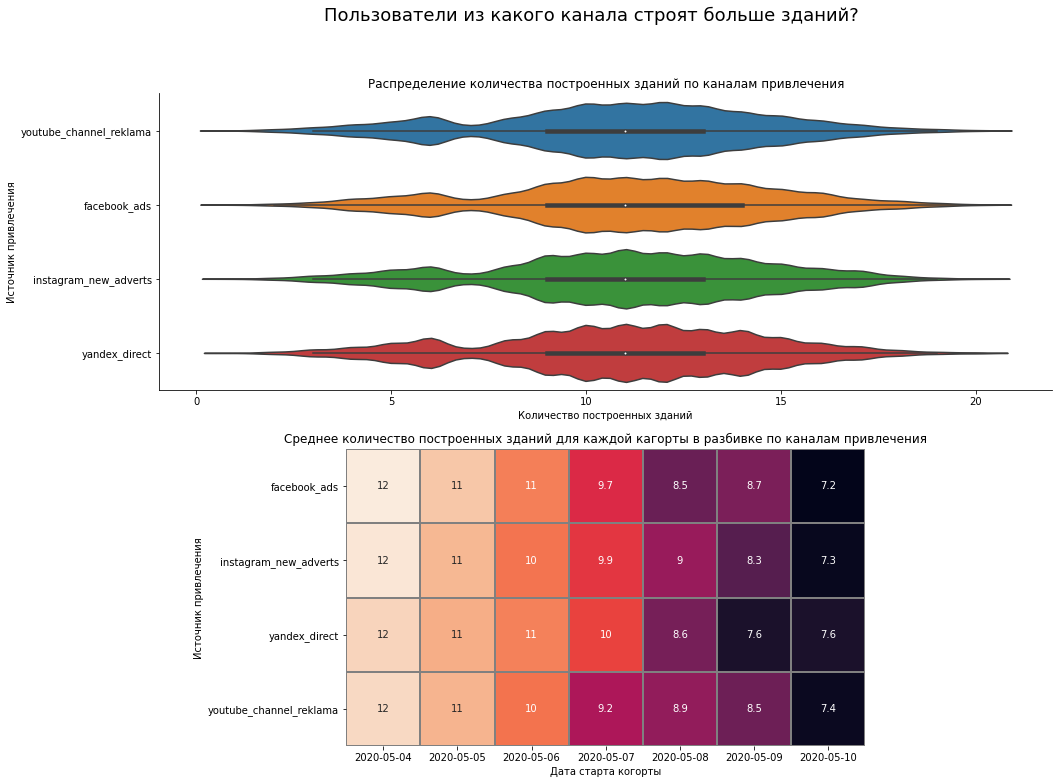

In [37]:
# Визуализируем полученные данные:
plt.figure(figsize=(16, 12)).suptitle('Пользователи из какого канала строят больше зданий?', fontsize = 18)
plt.subplot(2, 1, 1)
sns.violinplot(data = users, x = 'buildings_built', y = 'source')
sns.despine()
plt.xlabel("Количество построенных зданий")
plt.ylabel("Источник привлечения")
plt.title("Распределение количества построенных зданий по каналам привлечения")

plt.subplot(2, 1, 2)
sns.heatmap(df,
           annot = True, 
           linewidths=1,
           linecolor='gray',
           cbar=0,
           square=True)
plt.xlabel("Дата старта когорты")
plt.ylabel("Источник привлечения")
plt.title("Среднее количество построенных зданий для каждой кагорты в разбивке по каналам привлечения")
plt.show()

- Как показывают графики, поведение пользователей в контексте строительства зданий практически не отличается от одного канала привлечения к другому;
- Интересный факт, что пользователи, привлеченные на старте рекламной компании, строят в среднем больше зданий, чем пользователи, привлеченные на исходе рекламной компании.

### 4.4 Пользователи из какого канала больше и чаще заходят в игру?

In [38]:
# Определим сколько примерно часов провёл каждый пользователь в игре в течение первых двух дней:

# Отберём только те события, которые произошли в пределах первых двух дней игрока в игре:
users_filtered = users.query('event_lifetime < @pd.Timedelta("3 days")')
# Добавим столбец, который будет содержать информацию о том, в каком часу произошло событие:
users_filtered['hour'] = users_filtered['event_datetime'].dt.hour
# При помощи сводной таблицы определим сколько примерно пользователь провёл за игрой в определенный день:
users_filtered = pd.pivot_table(data = users_filtered,
                                index = 'user_id',
                                columns = 'date',
                                values = 'hour',
                                aggfunc = 'count').fillna(0).reset_index()
# Теперь найдём суммарное количество часов, проведенное в игре каждым пользователем в течение первых дней:
users_filtered['total_hours_first_days'] = users_filtered.sum(axis = 1)
users_filtered = users_filtered[['user_id', 'total_hours_first_days']]
# Мёрджим полученный результат к "рабочему" датафрейму users:
users = users.merge(users_filtered, how = 'left', on = 'user_id')

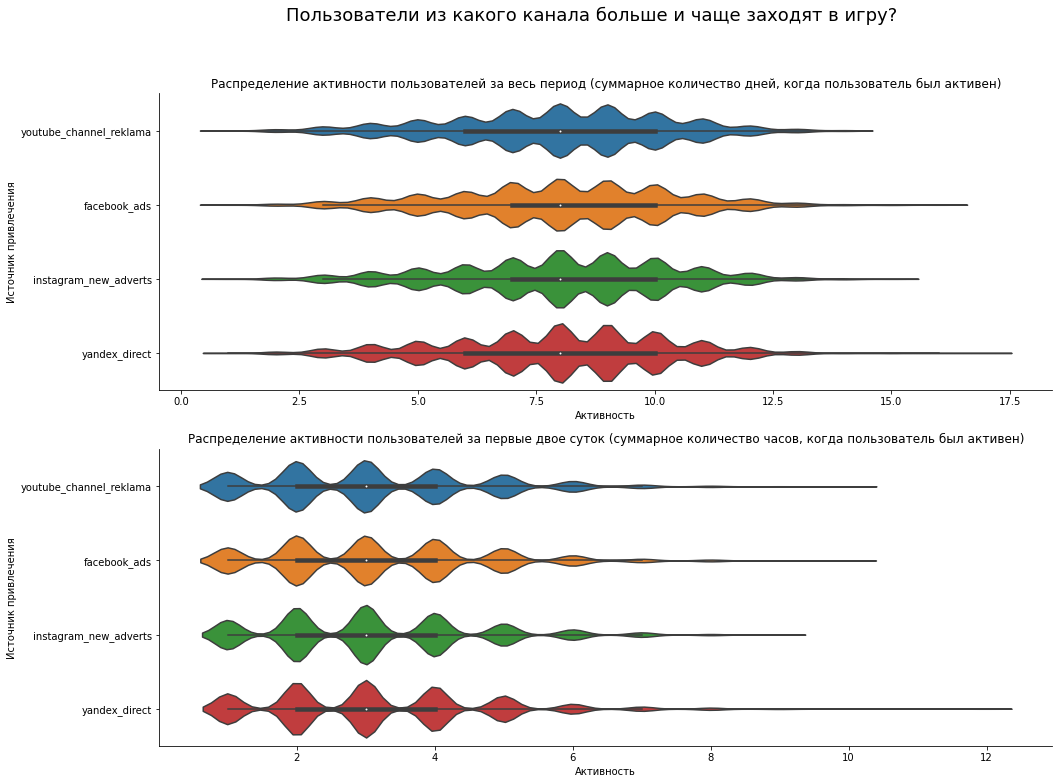

In [39]:
plt.figure(figsize=(16, 12)).suptitle('Пользователи из какого канала больше и чаще заходят в игру?', fontsize = 18)
plt.subplot(2, 1, 1)
sns.violinplot(data = users, y = 'source', x = 'days_in_game_present')
sns.despine()
plt.ylabel("Источник привлечения")
plt.xlabel("Активность")
plt.title("Распределение активности пользователей за весь период (суммарное количество дней, когда пользователь был активен)")
plt.subplot(2, 1, 2)
sns.violinplot(data = users, y = 'source', x = 'total_hours_first_days')
sns.despine()
plt.ylabel("Источник привлечения")
plt.xlabel("Активность")
plt.title("Распределение активности пользователей за первые двое суток (суммарное количество часов, когда пользователь был активен)")
plt.show()

- Пользователи, привлеченные из различных источников, показывают одинаковое игровое поведение в разрезе проведенного времени в игре.

### 4.5 Какой канал предоставляет большую конверсию игроков первого уровня в игроков второго уровня?

In [40]:
# Добавим в датафрейм users столбец с информацией о том, достиг ли пользователь второго уровня:
users_achived_first_level = users.query('event == "finished_stage_1"')['user_id']
users['has_finished_stage_1'] = np.where(users['user_id'].isin(users_achived_first_level), 1, 0)

In [41]:
# Посчитаем количество игроков, достигших второго уровня, в разбивке по каналам привлечения:
reached_second_level = (users.query('has_finished_stage_1 == 1').groupby('source')
                        .agg(reached_second_level = ('user_id', 'nunique'))
                        .reset_index()
                       )

In [42]:
# Посчитаем суммарное количество игроков, привлеченных из каждого отдельного канала:
nunique_first_level = users.groupby('source').agg(nunique_first_level = ('user_id', 'nunique')).reset_index()

In [43]:
# Рассчитаем конверсию игроков первого уровня в игроков второго уровня по каналам:
conversion = nunique_first_level.merge(reached_second_level, how = 'outer', on = 'source')
conversion['conversion, %'] = conversion['reached_second_level'] / conversion['nunique_first_level']
conversion

,source,nunique_first_level,reached_second_level,"conversion, %"
0,facebook_ads,2726,1150,0.421864
1,instagram_new_adverts,3347,1466,0.438004
2,yandex_direct,4817,2042,0.423915
3,youtube_channel_reklama,2686,1159,0.431497


- Значимых различий в конверсиях между источниками привлечения нет.

### 4.6 Каково соотношение PVE и PVP игроков, привлеченных из различных каналов?

In [44]:
# Определим игроков, которые перешли на следующий уровень путём завершения исследования проекта:
pve_players = users.query('has_finished_stage_1 == 1 and project_type == "satellite_orbital_assembly"')['user_id']

In [45]:
# Добавим в датафрейм колонку с информацией о том, каким образом игрок завершил первый уровень (PVE/PVP):
users['PVE/PVP'] = np.where(users['user_id'].isin(pve_players), "PVE", "not_stated")

In [46]:
# Определим игроков, которые перешли на следующий уровень путём победы над первым игроком:
pvp_players = users.query('has_finished_stage_1 == 1')
pvp_players = pvp_players[~pvp_players['user_id'].isin(pve_players)]['user_id'].unique()

In [47]:
# Добавим в датафрейм информацию о PVP игроках:
users.loc[users['user_id'].isin(pvp_players), 'PVE/PVP'] = 'PVP'

In [48]:
# Рассчитаем, какое количество PVE и PVP игроков было привлечено из каждого рекламного канала:
pve_per_source = (users[users['PVE/PVP'] == 'PVE'].groupby('source')
                      .agg(nunique_pve = ('user_id', 'nunique'))
                      .reset_index()
                 )

pvp_per_source = (users[users['PVE/PVP'] == 'PVP'].groupby('source')
                      .agg(nunique_pvp = ('user_id', 'nunique'))
                      .reset_index()
                 )

pve_pvp_per_source = pve_per_source.merge(pvp_per_source, how = 'inner', on = 'source')

In [49]:
# Вычислим отношение количества PVP игроков к количеству PVE игроков для каждого канала:
pve_pvp_per_source['pve_ratio'] = (pve_pvp_per_source['nunique_pve'] /
                                   (pve_pvp_per_source['nunique_pvp'] + pve_pvp_per_source['nunique_pve'])
                                  )
pve_pvp_per_source.sort_values(by = 'pve_ratio', ascending = False)

,source,nunique_pve,nunique_pvp,pve_ratio
0,facebook_ads,391,759,0.340000
3,youtube_channel_reklama,379,780,0.327006
1,instagram_new_adverts,476,990,0.324693
2,yandex_direct,620,1422,0.303624


- Как видно, каналы отличаются по соотношению количества PVE игроков к количеству PVP игроков, хоть и очень незначительно;
- Для того чтобы понять как трактовать данную информацию, необходимо понять, какие игроки (PVE или PVP) более интересны бизнесу.

#### Кто в среднем больше строит зданий, PVE или PVE игроки?

In [50]:
# Вычислим среднее количество зданий, возводимых PVE игроками:
pve_mean = (users[users['PVE/PVP'] == 'PVE'].groupby('source')
            .agg(pve_gamers = ('buildings_built', 'mean')).reset_index()
           )

In [51]:
# Вычислим среднее количество зданий, возводимых PVP игроками:
pvp_mean = (users[users['PVE/PVP'] == 'PVP'].groupby('source')
            .agg(pvp_gamers = ('buildings_built', 'mean')).reset_index()
           )

In [52]:
# Объединим датафреймы и подготовим данные к визуализации:
pve_pvp_mean = pvp_mean.merge(pve_mean, how = 'inner', on = 'source')
pve_pvp_mean = pve_pvp_mean.set_index('source').stack().reset_index()
pve_pvp_mean.columns = ['source', 'pve_pvp', 'mean_buildings']

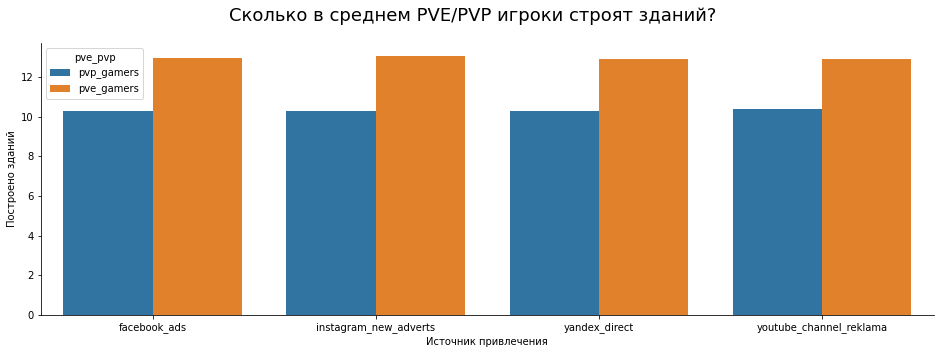

In [53]:
# Посмотрим, как различается среднее количество построенных зданий у PVE и PVP игроков:
plt.figure(figsize=(16, 5)).suptitle('Сколько в среднем PVE/PVP игроки строят зданий?', fontsize = 18)
sns.barplot(data = pve_pvp_mean, x = 'source', y = 'mean_buildings', hue = 'pve_pvp')
sns.despine()
plt.xlabel("Источник привлечения")
plt.ylabel("Построено зданий")
plt.show()

- Видно, что PVE игроки в среднем на двадацать - тридцать процентов строят больше зданий, нежели PVP игроки.
- Так как предварительная модель монетизации игры предполагает показ рекламы на экране с выбором типа объекта для постройки, то можно с уверенностью сказать, что PVE игроки более выгодны для безнеса, чем PVP игроки.
- Ранее было определено, что разные каналы привлекают разное соотношение PVE и PVP игроков: facebook_ads(34%), youtube_channel_reklama(33%), instagram_new_advers(32%), yandex_direct(30%).

### 4.7 Краткий вывод по итогам исследовательского анализа данных
При анализе каналов привлечения были получены следующие выводы:
- Игроки из разных каналов во многом демонстрируют практически не отличающееся друг от друга игровое поведение:
    - в среднем строят одинаковое количество зданий;
    - в среднем с одинаковой частотой заходят в игру;
    - в среднем имеют одинаковое удержание в игре;
- Стоимость привлечения пользователей значительно отличается от канала к каналу: 
    - стоимость пользователей из канала facebook_ads(0.79) в два раза больше стоимости пользователей из канала youtube_channel_reklama(0.40);
    - пользователи из канала instagram_new_advers(0.65) почти в полтора раза дороже чем пользователи из канала yandex_direct(0.46);
- Игроки, перешедшие на следующий уровень путём завершения исследования проекта, примерно на двадцать - тридцать процентов строят больше зданий, чем игроки, перешедшие на следующий уровень засчёт победы над первым противником.
- Каждый рекламный канал привлекает примерно одинаковое соотношение PVE/PVP игроков;
- Конверсия из игроков первого уровня в игроков второго уровня у всех каналов практически одинакова.

## 5. Статистический анализ данных

### 5.1 Проверка гипотезы: время завершения уровня различается у пве и пвп игроков

#### Формулировка гипотез:
- *Нулевая гипотеза* ${H_{0}}$: среднее время завершения первого уровня между PvP-игроками и PvE-игроками равно; 
- *Альтернативная гипотеза* ${H_{1}}$: среднее время завершения первого уровня между PvP-игроками и PvE-игроками различно;

In [54]:
# Подготовим данные для проведения теста. Определим в днях, сколько потребовалось времени, чтобы набрать второй уровень:
pve_users = users.loc[(users['PVE/PVP'] == 'PVE') & (users['event'] == 'finished_stage_1')]['event_lifetime'].dt.days
pvp_users = users.loc[(users['PVE/PVP'] == 'PVP') & (users['event'] == 'finished_stage_1')]['event_lifetime'].dt.days

In [55]:
# Проверяем гипотезу о равенстве средних двух совокупностей:
alpha = 0.05
result = st.ttest_ind(pvp_users, pve_users, equal_var = False)
print('p-значение:', result.pvalue)

if result.pvalue < alpha:
    print("Отвергаем нулевую гипотезу") 
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 6.5704667556440105e-105
Отвергаем нулевую гипотезу


In [56]:
print("Среднее время завершения первого уровня для PVE игрока равно {:.3} дней".format(pve_users.mean()))
print("Среднее время завершения первого уровня для PVP игрока равно {:.3} дней".format(pvp_users.mean()))
print("Среднее время завершения первого уровня для PVE игрока больше среднего времени завершения первого уровня для PVP игрока на  {:.3} процентов".format((pve_users.mean() / pvp_users.mean() - 1) * 100))

Среднее время завершения первого уровня для PVE игрока равно 13.4 дней
Среднее время завершения первого уровня для PVP игрока равно 11.1 дней
Среднее время завершения первого уровня для PVE игрока больше среднего времени завершения первого уровня для PVP игрока на  21.1 процентов


### 5.2 Проверка гипотезы: пве и пвп игроки строят разное количество зданий:

#### Формулировка гипотез:
- *Нулевая гипотеза* ${H_{0}}$: среднее количество построенных зданий между PvP-игроками и PvE-игроками равно; 
- *Альтернативная гипотеза* ${H_{1}}$: среднее количество построенных зданий между PvP-игроками и PvE-игроками различно;

In [57]:
pve_users = users.loc[users['PVE/PVP'] == 'PVE'].groupby('user_id', as_index = False).agg({'buildings_built' : 'max'})['buildings_built']
pvp_users = users.loc[users['PVE/PVP'] == 'PVP'].groupby('user_id', as_index = False).agg({'buildings_built' : 'max'})['buildings_built']

In [58]:
alpha = .05 #критический уровень статистической значимости
result = st.mannwhitneyu(pvp_users, pve_users) #проверяем гипотезу о равенстве средних двух совокупностей
print('p-значение:', result.pvalue)
if result.pvalue < alpha:
    print("Отвергаем нулевую гипотезу") 
else:
    print("Не получилось отвергнуть нулевую гипотезу") 


p-значение: 5.211926275022306e-305
Отвергаем нулевую гипотезу


In [59]:
print("Среднее количество построенных зданий для PVE игрока равно {:.3} дней".format(pve_users.mean()))
print("Среднее количество построенных зданий для PVP игрока равно {:.2} дней".format(pvp_users.mean()))
print("Среднее количество построенных зданий для PVE игрока больше среднего количества построенных зданий для PVP игрока  на {:.3} процентов".format((pve_users.mean() / pvp_users.mean() - 1) * 100))

Среднее количество построенных зданий для PVE игрока равно 12.6 дней
Среднее количество построенных зданий для PVP игрока равно 9.4 дней
Среднее количество построенных зданий для PVE игрока больше среднего количества построенных зданий для PVP игрока  на 34.4 процентов


## 6. Финальный вывод

В ходе данного проекта были установлены следующие закономерности:
- Значимых различий в удержании пользователей из разных каналов привлечения нет.
- Стоимость привлечения одного пользователя из каждого отдельно взятого канала оставалась стабильной на протяжении всей рекламной компании. При этом пользователи из каналов facebook_ads и instagram_new_advers обходились заметно дороже для рекламного бюджета, нежели пользователи из каналов yandex_direct и youtube_channel_reklama. Так, стоимость пользователей из канала facebook_ads(0.79) в два раза больше стоимости пользователей из канала youtube_channel_reklama(0.40), а пользователи из канала instagram_new_advers(0.65) почти в полтора раза дороже чем пользователи из канала yandex_direct(0.46).
- Больше всего пользователей было привлечено из каналов yandex_direct(35%) и instagram_new_adverts(25%).
- Меньше всего пользователей было привлечено из каналов facebook_ads(20%) и youtube_channel_reklama(20%).
- На все источники привлечения рекламный бюджет выделялся в равном объеме, за исключением youtube_channel_reklama, средств на который тратилось в два раза меньше. 
- Поведение пользователей в контексте строительства зданий практически не отличается от одного канала привлечения к другому;
- Пользователи, привлеченные из различных источников, показывают одинаковое игровое поведение в разрезе проведенного времени в игре.
- Каналы незначительно отличаются друг от друга по соотношению количества PVE игроков к количеству PVP игроков;
- Значимых различий в конверсиях из игроков первого уровня в игроков второго уровня между источниками привлечения нет.

Также, при помощи статистического анализа были проверены две гипотезы и установлено, что
- Среднее количество зданий, которые возводит PVE игрок, больше среднего количества зданий, которые возводит PVP игрок.
- Средний PVE игрок тратит больше времени, чтобы перейти на второй уровень, чем PVP игрок.


**Рекомендации**:
- При планировании следующей рекламной компании, следует обратить внимание на youtube и yandex_direct, ведь стоимость привлечения в игру пользователей из этих источников значительно меньше, чем стоимость привлечения пользователей из других источников, в то время как их игровое поведение ничем не отличается от остальных игроков.  
- Было установлено, что значимая часть игроков не стремится переходить на следующий уровень. Многим просто нравится строить здания. Также было определено, что PVE игроки на 20-30% больше строят зданий, чем PVP игроки. Возможно, в следующей рекламной компании стоит дополнительно отметить, что в нашей игре есть вот такие нестандартные сценарии поведения.